## Member Segmentation | Unsupervised Learning

This notebook presents a simple demonstration of member segmentation task for an independent retail pharmacy's targeted marketing campaign. The key objective of this task is to group similar members together based on their previously purchased products at the store. Each segment tells a different story about customer values and needs.

### Experimental Data

The dataset used contains mostly behavioral data of about 100 members, including their past transactional data. 

In [98]:
# Load libraries
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt  
import numpy as np
import seaborn as sns
import random
from sklearn.decomposition import PCA 
from sklearn.mixture import GaussianMixture   
np.seterr(divide='ignore', invalid='ignore')
%matplotlib inline 

In [99]:
# read data
member_transactions = pd.read_csv('data/member_transactions.csv',header=0,skip_blank_lines=True) 
product_balance = pd.read_csv('data/product_balance.csv',header=0,skip_blank_lines=True)
product_details = pd.read_csv('data/product_details.csv',header=0,skip_blank_lines=True)

### Data Preprocessing

In [100]:
member_transactions = member_transactions.dropna(0,"all")
member_transactions = member_transactions.dropna(1,"all")

member_cn_amt = member_transactions.loc[(member_transactions['INVOICE #'].str.startswith('CN')),'TOTAL SALES']
member_transactions.loc[(member_transactions['INVOICE #'].str.startswith('CN')),'TOTAL SALES'] = member_cn_amt *(-1)
member_transactions['DATE'] = member_transactions['DATE'].str.slice(0,10)
member_transactions['DATE'] = pd.to_datetime(member_transactions['DATE'])

member_transactions['MEMBER CODE'] = member_transactions['MEMBER CODE'].str.strip()
member_transactions = member_transactions[~member_transactions['PRODUCT CODE'].str.startswith('M-POI')]

member_product = member_transactions[['MEMBER CODE','DESCRIPTION']]
member_product = pd.get_dummies(member_product, columns=["DESCRIPTION"])
member_product = member_product.groupby('MEMBER CODE').sum()
member_product = member_product.rename(columns = lambda x : str(x)[12:])

categories_dict = pd.Series(product_details['Group'].values,index=product_details['Product Code']).to_dict()
brands_dict = pd.Series(product_details['Brand'].values,index=product_details['Product Code']).to_dict()
member_transactions['Category'] = member_transactions['PRODUCT CODE'].map(categories_dict)
member_transactions['Brand'] = member_transactions['PRODUCT CODE'].map(brands_dict)

product_balance = product_balance.dropna(0,'all')
product_details = product_details.dropna(0,'all')

#### Create dummy variables

In [101]:
member_cat = member_transactions[['MEMBER CODE','Category']]
member_cat = pd.get_dummies(member_cat, columns=["Category"],dummy_na=False)
member_cat = member_cat.groupby('MEMBER CODE').sum()
member_cat = member_cat.rename(columns = lambda x : str(x)[9:])

member_brand = member_transactions[['MEMBER CODE','Brand']]
member_brand = pd.get_dummies(member_brand, columns=["Brand"],dummy_na=False)
member_brand = member_brand.groupby('MEMBER CODE').sum()
member_brand = member_brand.rename(columns = lambda x : str(x)[6:])

member_trans = member_product.join(member_cat)
member_trans = member_trans.join(member_brand)

In [102]:
member_trans.shape

(111, 851)

A sample of the resultant dataset looks like:

![](https://s3-ap-southeast-1.amazonaws.com/mhlee2907/data_sample.PNG)

### Reduce dimension of data

Reduce the data dimension for better performance since we have 800+ columns.

In [103]:
# Transform the data to two dimensions
pca = PCA(n_components=2)             
pca.fit(member_trans)                      
member_pca = pca.transform(member_trans)         
member_pca

array([[ 3.92625140e+00,  1.43855627e+00],
       [ 5.89954434e+00,  4.13068582e+00],
       [-2.80879107e+00, -2.66062871e+00],
       [-2.35217768e+00, -3.34360690e+00],
       [-4.33648569e+00, -1.31226030e+00],
       [-6.51171243e+00, -4.76984265e-01],
       [-3.29003457e+00,  5.89450986e-01],
       [-5.91727986e+00, -8.42672791e-02],
       [-7.05301348e+00, -1.01824073e+00],
       [-5.52919807e+00, -1.84739436e+00],
       [-3.89539667e+00, -9.58611303e-02],
       [ 3.55762349e+00,  7.55200747e-01],
       [-5.29644092e+00, -1.79362928e+00],
       [ 8.30136774e-01,  3.74213721e+00],
       [ 1.19981443e+00, -3.28799876e+00],
       [-2.85482401e+00,  4.14630071e+00],
       [-3.12376799e+00, -1.10820926e+00],
       [-4.71881919e+00, -2.18867502e+00],
       [-6.03516521e+00, -1.54596687e+00],
       [-1.99841128e+00, -5.55976051e-01],
       [ 1.39524344e+01, -3.33742885e-01],
       [-6.86404598e+00, -8.87462056e-01],
       [ 6.00308507e+00,  2.79778012e+00],
       [-6.

In [19]:
member_pca.shape

(111, 2)

### Gaussian Mixture Clustering

In [128]:
# cluster members into 6 segments
model = GaussianMixture(n_components = 6,
            covariance_type='full',random_state =123)           
model.fit(member_pca)                            
y = model.predict(member_pca)
y

array([4, 4, 0, 4, 0, 0, 0, 0, 0, 0, 0, 4, 0, 4, 4, 4, 0, 0, 0, 0, 5, 0,
       4, 0, 0, 0, 4, 0, 0, 4, 0, 0, 0, 4, 4, 5, 0, 0, 0, 0, 0, 4, 4, 0,
       0, 4, 4, 4, 0, 0, 4, 5, 4, 0, 0, 0, 3, 0, 0, 0, 0, 3, 4, 0, 0, 0,
       0, 4, 0, 4, 0, 0, 0, 0, 4, 0, 0, 1, 4, 5, 4, 0, 0, 4, 4, 0, 4, 0,
       0, 0, 3, 0, 4, 0, 0, 4, 0, 0, 4, 0, 0, 0, 2, 0, 0, 0, 0, 4, 0, 0,
       0], dtype=int64)

In [129]:
member_trans['cluster'] = y
member_pca_df = pd.DataFrame(member_pca,columns = ['PCA 1','PCA 2'])
member_pca_df['cluster'] = y
member_pca_df['cluster'] = member_pca_df['cluster'].astype('category')

# remove outliers
member_pca_df = member_pca_df[member_pca_df['PCA 1'] < 60]

#### Plotting the segments

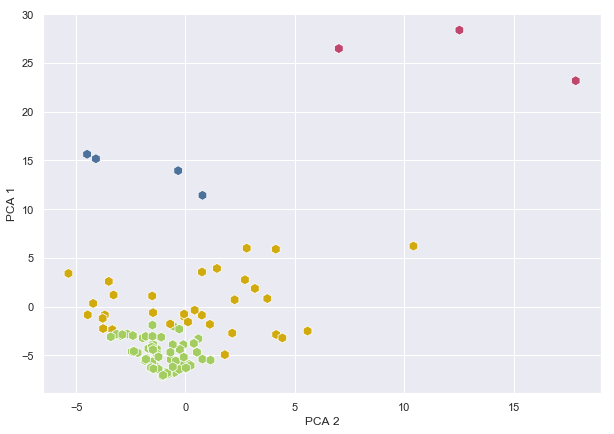

In [132]:
plt.figure(figsize=(10, 7))
sns.set()

palette = ['#a3cc61','#38afa7','#8a6da3','#bf466c','#d1aa0e','#4c729b']
ax = sns.scatterplot(x="PCA 2", y="PCA 1", hue="cluster", data=member_pca_df,marker="h",s=100,legend=False,palette = palette)